In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import math
import matplotlib as mpl
#mpl.use('pdf')
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import matplotlib
import matplotlib.patheffects as path_effects
import seaborn as sns
import scipy

colors = ["#FFE599", "#CF597E", "#C3ABD0", "#B9E0A5", "#089099"]# Set your custom color palette
color_map = list(map(lambda x: sns.desaturate(x,0.9),colors))
sns.set_palette(color_map)
sns.color_palette() 


[(0.98, 0.8882352941176471, 0.6200000000000001),
 (0.7886274509803921, 0.37215686274509796, 0.5027450980392157),
 (0.7625490196078432, 0.677843137254902, 0.8084313725490196),
 (0.7292156862745098, 0.8668627450980392, 0.6586274509803921),
 (0.05980392156862746, 0.5398039215686272, 0.5715686274509804)]

In [2]:


def PARALia_log_read(filename):
    temp = pd.read_csv(filename, header=None, names = ['T','dev_num', 'dev_id_token', 'cachesize_limit','TransA','TransB',
                                                    'alpha','beta','M','N','K','Asloc','Bsloc','Csloc', 'CsOutloc', 'timer', 'pred_t', 'pred_J'], 
                                                     dtype = {'M': np.int64, 'N': np.int64, 'K': np.int64, 'timer': np.float64, 'pred_t': np.float64, 'pred_J': np.float64} )
    temp.sort_values(by=['M','N','K'])
    return temp

def keep_dev_num(num, dataframe):
    return dataframe[dataframe['dev_num'] == num]

machine = 'karol'
homedir = '~/karol_strong_scaling_results_20-06-2024/'
devices = 8
#Mmax = ?
#MemMax = 28*(1024*1024*1024) # Questionable limit
Rmax_Gflops = 15*1024*devices
dev_W_avg = 400

dataset = pd.DataFrame()

XKBLAS_allin = PARALia_log_read('%sxkblas-v0.4-bare-1600/XKBLAS_dgemm_runner_0.4_1600_interhost_strong_scaling.log' %(homedir))
scenario_name="XKBLAS"
XKBLAS_allin['Asloc'][XKBLAS_allin['Asloc'] == 8] = 9
XKBLAS_allin['Bsloc'][XKBLAS_allin['Bsloc'] == 8] = 9
XKBLAS_allin['Csloc'][XKBLAS_allin['Csloc'] == 8] = 9
print('XKBLAS_allin len: %d\n' % len(XKBLAS_allin))
XKBLAS_allin['imp'] = scenario_name
XKBLAS_allin['plot_order'] = 1
dataset = pd.concat([dataset,XKBLAS_allin])

scenario_name="taco-paralia-1.5-fixed-streams"
PARALiA15_taco_fixed = PARALia_log_read('%sPARALiA-Framework-1.5/CoCoPeLiaDgemmRunner_predefined_vals_ST-2D-BLOCK-CYCLIC__UN-PB-L8_ALL-HOPS-1-0.20_PW-PRED-PERF_1.5.log' %(homedir))
print('PARALiA15_taco_fixed len: %d\n' % len(PARALiA15_taco_fixed))
PARALiA15_taco_fixed['imp'] = scenario_name
PARALiA15_taco_fixed['plot_order'] = 2
dataset = pd.concat([dataset,PARALiA15_taco_fixed])

scenario_name="cuBLASXt"
version="2.99"
cuBLASXt_allin = PARALia_log_read('%sPARALiA-GEMMex-strong-scaling-bench/cuBLASXtDgemmRunner_predefined_vals_%s_strong_scaling_bench.log' %(homedir, version))
print('cuBLASXt_allin len: %d\n' % len(cuBLASXt_allin))
cuBLASXt_allin['imp'] = scenario_name
cuBLASXt_allin['plot_order'] = 0
dataset = pd.concat([dataset,cuBLASXt_allin])

scenario_name="qeta-mineta-auto-reptile-fastev"
comp_streams="COMP_STREAMS_PERDEV-8"
streaming_overlap="COMM_STREAM_BUFFERING-8"
algo="ALGO_AUTO"
account_for_tile_sl="_MODEL-TILE-SL"
distribution="2D-BLOCK-CYCLIC-D1_lesseq_D2"
fetch_routing="FETCH-CHAIN-QETA"
wb_routing="WB-P2P-INIT"
task_order="TASK-ORDER-QETA"
pw_optimize="PW-PRED-PERF"
reptile="REPTILE-5"
version="2.99"
PARALiA2_chain_qeta_mineta_auto_reptile_fastev = (PARALia_log_read('%sPARALiA-GEMMex-strong-scaling-bench/dgemm_runner_predefined_vals__%s_%s_%s%s_%s_%s_%s_%s_%s_%s_%s_strong_scaling_bench.log' 
    %(homedir, comp_streams, streaming_overlap, algo, account_for_tile_sl, distribution, fetch_routing, wb_routing, task_order, pw_optimize, reptile, version)))
print('PARALiA2_chain_qeta_mineta_auto_reptile_fastev len: %d\n' % len(PARALiA2_chain_qeta_mineta_auto_reptile_fastev))
PARALiA2_chain_qeta_mineta_auto_reptile_fastev['imp'] = scenario_name
PARALiA2_chain_qeta_mineta_auto_reptile_fastev['plot_order'] = 3
dataset = pd.concat([dataset,PARALiA2_chain_qeta_mineta_auto_reptile_fastev])


XKBLAS_allin len: 30800

PARALiA15_taco_fixed len: 17352

cuBLASXt_allin len: 5720

PARALiA2_chain_qeta_mineta_auto_reptile_fastev len: 5710



In [3]:
def PARALiA_grouby_avg(df):
    result = df.groupby(['dev_num', 'dev_id_token', 'cachesize_limit','TransA','TransB',
        'alpha','beta','M','N','K','Asloc','Bsloc','Csloc', 'CsOutloc', 'flops', 'bytes', 'loc_str', 'imp', 'plot_order'], as_index=False, sort=True).mean()
    #print(result)
    return result

def PARALiA_grouby_max(df):
    result = df.groupby(['T','dev_num', 'dev_id_token', 'cachesize_limit','TransA','TransB',
        'alpha','beta','M','N','K','Asloc','Bsloc','Csloc', 'CsOutloc', 'flops', 'bytes', 'loc_str', 'imp', 'plot_order'], as_index=False, sort=True).max()
    #print(result)
    return result

def PARALiA_select_subset(df, subset_str):
    if subset_str == 'square': 
        return df.loc[(df['M'] == df['N']) & (df['M'] == df['K'])]
    elif subset_str == 'fat-thin':
        return df.loc[(df['M'] == df['N']) & (df['M'] > df['K'])]
    elif subset_str == 'thin-fat':        
        return df.loc[(df['M'] == df['N']) & (df['M'] < df['K'])]
    
def PARALiA_select_indata_locs(df, loc1, loc2, loc3):
    return df.loc[(df['Asloc'] == loc1) & (df['Bsloc'] == loc2) & (df['Csloc'] == loc3)]

def dgemm_flops(df):
    df['flops'] = df['M']*df['N']*(2*df['K'] + 2)
    return df['M']*df['N']*(2*df['K'] + 2)
def dgemm_bytes(df):
    df['bytes'] = 8*(df['M']*(df['N']+df['K']) + df['N']*df['K']) 
    return 8*(df['M']*(df['N']+df['K']) + df['N']*df['K']) 

def add_median_labels(ax: plt.Axes, offset: int, fmt: str = "d") -> None:
    """Add text labels to the median lines of a seaborn boxplot.

    Args:
        ax: plt.Axes, e.g. the return value of sns.boxplot()
        fmt: format string for the median value
    """
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if "Patch" in str(c)]
    start = 4
    if not boxes:  # seaborn v0.13 => fill=False => no patches => +1 line
        boxes = [c for c in ax.get_lines() if len(c.get_xdata()) == 5]
        start += 1
    lines_per_box = len(lines) // len(boxes)
    for median in lines[start::lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if len(set(median.get_xdata())) == 1 else y
        text = ax.text(x, y + offset, f'{int(value):{fmt}}', ha='center', va='center',
                       color='white', fontsize = font-1) #fontweight='bold', 
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground=median.get_color()),
            path_effects.Normal(),
        ])

In [4]:
font=8
#plt.rc('font', family='serif', serif='Times') #annoying warning filling my view, so disabled until needed
#plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=font)
plt.rc('ytick', labelsize=font)
plt.rc('axes', labelsize=font)
plt.rc('figure', titlesize=font)
# width as measured in inkscape
width = 3.487
height = width / 1.618

#fig, ax = plt.subplots()
#fig.subplots_adjust(left=.15, bottom=.17, right=.99, top=.97)

In [5]:
dgemm_bytes(dataset)
dgemm_flops(dataset)
dataset['pred_t'] = dataset['pred_J'] = 0
dataset['perf'] = dataset['flops']/(1e9*dataset['timer'])
dataset['energy'] = dataset['timer']*(dev_W_avg* dataset['dev_num'])
dataset['EDP'] = (dataset['perf'])*(dataset['perf'])/(dev_W_avg* dataset['dev_num'])
dataset['PDP'] = dataset['flops']/(1e9*dataset['energy'])
dataset['Asloc'][dataset['Asloc'] == 12] = -1
dataset['Bsloc'][dataset['Bsloc'] == 12] = -1
dataset['Csloc'][dataset['Csloc'] == 12] = -1
dataset['Asloc'][dataset['Asloc'] == 9] = -1
dataset['Bsloc'][dataset['Bsloc'] == 9] = -1
dataset['Csloc'][dataset['Csloc'] == 9] = -1
dataset['Asloc'][dataset['Asloc'] == 8] = -2
dataset['Bsloc'][dataset['Bsloc'] == 8] = -2
dataset['Csloc'][dataset['Csloc'] == 8] = -2
#dataset['Asloc'][dataset['Asloc'] == -2] = -1
#dataset['Bsloc'][dataset['Bsloc'] == -2] = -1
#dataset['Csloc'][dataset['Csloc'] == -2] = -1
dataset['loc_str'] = 100*(dataset['Csloc']+1) + 10*(dataset['Bsloc']+1) + dataset['Asloc']+1
for imp in dataset['imp'].unique().tolist():
    temp_dataset = dataset[dataset['imp'] == imp]
    print("Implementation %s : mean of %d cases -> perf = (ar = %.2lf, ar/ar = %.2lf, geomean = %.2lf, harmonic = %.2lf) Tflops/s, Energy = %lf J, PDP = %lf, EDP = %lf" % 
        (imp, len(PARALiA_grouby_avg(temp_dataset)),
        PARALiA_grouby_avg(temp_dataset)['perf'].mean()/1e3,
        PARALiA_grouby_avg(temp_dataset)['flops'].mean()/PARALiA_grouby_avg(temp_dataset)['timer'].mean()/1e12,
        scipy.stats.mstats.gmean(PARALiA_grouby_avg(temp_dataset).loc[:,'perf'])/1e3, 
        scipy.stats.hmean(PARALiA_grouby_avg(temp_dataset).loc[:,'perf'])/1e3,
        PARALiA_grouby_avg(temp_dataset)['energy'].mean(), PARALiA_grouby_avg(temp_dataset)['PDP'].mean(),  PARALiA_grouby_avg(temp_dataset)['EDP'].mean()))

Implementation XKBLAS : mean of 280 cases -> perf = (ar = 18.00, ar/ar = 29.25, geomean = 8.03, harmonic = 2.41) Tflops/s, Energy = 424.585756 J, PDP = 11.834737, EDP = 368131.515803
Implementation taco-paralia-1.5-fixed-streams : mean of 174 cases -> perf = (ar = 28.32, ar/ar = 32.81, geomean = 16.66, harmonic = 6.95) Tflops/s, Energy = 323.099965 J, PDP = 21.810578, EDP = 817087.218178
Implementation cuBLASXt : mean of 52 cases -> perf = (ar = 9.32, ar/ar = 13.37, geomean = 3.42, harmonic = 1.25) Tflops/s, Energy = 941.105122 J, PDP = 8.046772, EDP = 175208.078138
Implementation qeta-mineta-auto-reptile-fastev : mean of 52 cases -> perf = (ar = 24.63, ar/ar = 30.91, geomean = 14.22, harmonic = 6.77) Tflops/s, Energy = 354.699477 J, PDP = 19.433574, EDP = 664210.871329


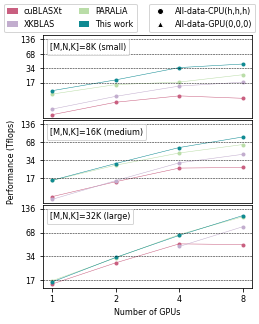

In [19]:
def enforce_gen_dataset_limits(df):
    return df[(df['dev_id_token']!= 1111) & 
    (df['dev_id_token']!= 11) ]

def is_square(df):
    return df[(df['M'] == df['N']) & (df['K'] == df['M']) ]

def full_offload(df):
    return df[(((df['Asloc'] == -1) & (df['Bsloc'] == -1)) & (df['Csloc'] == -1))]

def all_dev(df):
    return df[(((df['Asloc'] == 0) & (df['Bsloc'] == 0)) & (df['Csloc'] == 0))]

sns.set_palette(color_map[1:])
#sns.set_palette(cp3_2)
#sns.color_palette()

dataset_perf_comparisson = dataset[(dataset['imp'] == 'cuBLASXt') |
                        (dataset['imp'] == 'XKBLAS') |
                        #(dataset['imp'] == 'taco-paralia-1.5-malloc') |
                        (dataset['imp'] == 'taco-paralia-1.5-fixed-streams') |
                        #(dataset['imp'] == 'qeta-mineta-auto') |
                        #(dataset['imp'] == 'qeta-auto-reptile') |
                        #(dataset['imp'] == 'qeta-minfetch-auto-reptile')|
                        #dataset['imp'] == 'qeta-mineta-auto-reptile') |
                        (dataset['imp'] == 'qeta-mineta-auto-reptile-fastev')]
dataset_perf_comparisson['Asloc'][dataset_perf_comparisson['Asloc'] == -2] = -1
dataset_perf_comparisson['Bsloc'][dataset_perf_comparisson['Bsloc'] == -2] = -1
dataset_perf_comparisson['Csloc'][dataset_perf_comparisson['Csloc'] == -2] = -1
dataset_perf_comparisson['loc_str'] = 100*(dataset_perf_comparisson['Csloc']+1) + 10*(dataset_perf_comparisson['Bsloc']+1) + dataset_perf_comparisson['Asloc']+1
#dataset_perf_comparisson['imp'][dataset_perf_comparisson['imp'] == 'taco-paralia-1.5-fixed-streams'] = 'PARALiA'
#dataset_perf_comparisson['imp'][dataset_perf_comparisson['imp'] == 'qeta-mineta-auto-reptile-fastev'] = 'This work'

#dataset_perf_comparisson['imp'][dataset_perf_comparisson['loc_str'] == 0] = dataset_perf_comparisson['imp'] + '(h,h,h)'
#dataset_perf_comparisson['imp'][dataset_perf_comparisson['loc_str'] == 111] = dataset_perf_comparisson['imp'] + '(0,0,0)'

clean_dataset = enforce_gen_dataset_limits(PARALiA_grouby_avg(dataset_perf_comparisson))
clean_dataset['Performance (Tflops)'] = clean_dataset['perf']/1024
clean_dataset.to_csv('strong_scalability_dataset_export.csv', index = False)
sq_dataset_full_offload = is_square(full_offload(clean_dataset))
sq_dataset_all_dev = is_square(all_dev(clean_dataset))

implementation_names = ['cuBLASXt', 'XKBLAS', 'PARALiA', 'This work'] #
#sq_dataset['shape'] = 'Square\n( M = N = K )'
fig, ax = plt.subplots(3,1)
sq_dataset_full_offload.sort_values(inplace = True, by = ['plot_order'])
sq_dataset_all_dev.sort_values(inplace = True, by = ['plot_order'])

#sq_dataset_8192 = sq_dataset[(sq_dataset['M'] == sq_dataset['N']) & (sq_dataset['K'] == sq_dataset['N']) & (sq_dataset['N'] == 8192)] 
#sq_dataset_16384 = sq_dataset[(sq_dataset['M'] == sq_dataset['N']) & (sq_dataset['K'] == sq_dataset['N']) & (sq_dataset['N'] == 16384)] 
#sq_dataset_32768 = sq_dataset[(sq_dataset['M'] == sq_dataset['N']) & (sq_dataset['K'] == sq_dataset['N']) & (sq_dataset['N'] == 32768)] 
#axout = sns.lineplot(data=sq_dataset_8192, x = 'dev_num', y = 'Performance (Tflops)', hue = 'imp', ax=ax, marker = 'o', markersize = 4, linewidth = .5, markeredgewidth=0.0)
#axout = sns.lineplot(data=sq_dataset_16384, x = 'dev_num', y = 'Performance (Tflops)', hue = 'imp', ax=ax , marker = '^', markersize = 4, linewidth = .5, markeredgewidth=0.0)
#axout = sns.lineplot(data=sq_dataset_32768, x = 'dev_num', y = 'Performance (Tflops)', hue = 'imp', ax=ax , marker = 's', markersize = 4, linewidth = .5, markeredgewidth=0.0)

sq_dataset_FO_8192 = sq_dataset_full_offload[(sq_dataset_full_offload['M'] == sq_dataset_full_offload['N']) & (sq_dataset_full_offload['K'] == sq_dataset_full_offload['N']) & (sq_dataset_full_offload['N'] == 8192)] 
sq_dataset_AD_8192 = sq_dataset_all_dev[(sq_dataset_all_dev['M'] == sq_dataset_all_dev['N']) & (sq_dataset_all_dev['K'] == sq_dataset_all_dev['N']) & (sq_dataset_all_dev['N'] == 8192)] 
axout = sns.lineplot(data=sq_dataset_FO_8192, x = 'dev_num', y = 'Performance (Tflops)', hue = 'imp', ax=ax[0], marker = 'o', markersize = 4, linewidth = .5, markeredgewidth=0.0)
#axout = sns.lineplot(data=sq_dataset_AD_8192, x = 'dev_num', y = 'Performance (Tflops)', hue = 'imp', ax=ax[0] , marker = '^', markersize = 4, linewidth = .5, markeredgewidth=0.0)

sq_dataset_FO_16384 = sq_dataset_full_offload[(sq_dataset_full_offload['M'] == sq_dataset_full_offload['N']) & (sq_dataset_full_offload['K'] == sq_dataset_full_offload['N']) & (sq_dataset_full_offload['N'] == 16384)] 
sq_dataset_AD_16384 = sq_dataset_all_dev[(sq_dataset_all_dev['M'] == sq_dataset_all_dev['N']) & (sq_dataset_all_dev['K'] == sq_dataset_all_dev['N']) & (sq_dataset_all_dev['N'] == 16384)] 
axout = sns.lineplot(data=sq_dataset_FO_16384, x = 'dev_num', y = 'Performance (Tflops)', hue = 'imp', ax=ax[1], marker = 'o', markersize = 4, linewidth = .5, markeredgewidth=0.0)
#axout = sns.lineplot(data=sq_dataset_AD_16384, x = 'dev_num', y = 'Performance (Tflops)', hue = 'imp', ax=ax[1] , marker = '^', markersize = 4, linewidth = .5, markeredgewidth=0.0)

sq_dataset_FO_32768 = sq_dataset_full_offload[(sq_dataset_full_offload['M'] == sq_dataset_full_offload['N']) & (sq_dataset_full_offload['K'] == sq_dataset_full_offload['N']) & (sq_dataset_full_offload['N'] == 32768)] 
sq_dataset_AD_32768 = sq_dataset_all_dev[(sq_dataset_all_dev['M'] == sq_dataset_all_dev['N']) & (sq_dataset_all_dev['K'] == sq_dataset_all_dev['N']) & (sq_dataset_all_dev['N'] == 32768)] 
axout = sns.lineplot(data=sq_dataset_FO_32768, x = 'dev_num', y = 'Performance (Tflops)', hue = 'imp', ax=ax[2], marker = 'o', markersize = 4, linewidth = .5, markeredgewidth=0.0)
#axout = sns.lineplot(data=sq_dataset_AD_32768, x = 'dev_num', y = 'Performance (Tflops)', hue = 'imp', ax=ax[2] , marker = '^', markersize = 4, linewidth = .5, markeredgewidth=0.0)

ax_title_str = ['8K (small)', '16K (medium)', '32K (large)']
for itter in range(0,3):
    axit = ax[itter] 
    axit.get_legend().remove()
    # Custom labels, colors, and markers
    if itter == 0:
        a_val = 1
        circa = []
        for ctr in range(0,len(implementation_names)):
            circa.append(matplotlib.patches.Patch(facecolor=color_map[1:][ctr],alpha=a_val,label=implementation_names[ctr]))
        fig.legend(handles = circa,
                fontsize=font, loc = 'upper left',  fancybox = True, ncol=2, handlelength=1.3)

        #custom_labels = ['M=N=K=8192', 'M=N=K=16384', 'M=N=K=32768']
        custom_labels = ['All-data-CPU(h,h,h)', 'All-data-GPU(0,0,0)']
        custom_colors = ['k', 'k']
        custom_markers = ['o', '^']
        # Custom legend elements
        legend_elements1 = [matplotlib.lines.Line2D([0], [0], marker=marker, color='w', markerfacecolor=color, label=label, markersize=6)
                       for label, color, marker in zip(custom_labels, custom_colors, custom_markers)]
        fig.legend(loc = 'upper right', handles=legend_elements1,#bbox_to_anchor=(0.99, 0.81), #title="Speedup",  # Title for the legend
                fontsize=font, fancybox = True, ncol=1)
    #axit.set_ylim(top = 150)
    axit.set_xscale('log', base = 2)
    axit.set_yscale('log', base = 17)
    axit.yaxis.set_major_locator(matplotlib.ticker.FixedLocator([17,34,68,136]))
    axit.minorticks_off()
    axit.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,y: '{}'.format(int(x))))
    axit.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,y: '{}'.format(int(x))))
    axit.axhline(y = 17, color = 'k', linestyle = '--', linewidth = 0.5)
    axit.axhline(y = 17*2, color = 'k', linestyle = '--', linewidth = 0.5)
    axit.axhline(y = 17*4, color = 'k', linestyle = '--', linewidth = 0.5)
    axit.axhline(y = 17*8, color = 'k', linestyle = '--', linewidth = 0.5)
    title_string = "[M,N,K]=%s" %(ax_title_str[itter])
    lege = axit.legend(loc = 'upper left', labels = [title_string], fontsize = font, handlelength=0, handletextpad=0)
    #ax.set_title(title_string, loc = 'upper left')
    for item in lege.legendHandles:
        item.set_visible(False)
    #axit.set_title(title_string, fontsize = font)
    #plt.tick_params(bottom = False) 
    if itter == 2:
        axit.set_xlabel('Number of GPUs')
    else:
        axit.set_xlabel('')
        axit.set_xticklabels([])
        axit.set_xticks([])
    if itter != 1:
        axit.set_ylabel('')
#ax.set_xticklabels(elem_name, rotation = 15)
fig.set_size_inches(width, height*2.)
fig.subplots_adjust(left=.15, bottom=.082, right=.985, top=0.895, wspace=0.02, hspace=0.02)        
fig.savefig('Plots/Plot_testbed-%s_gflops_comp_strong_scaling_FP64.pdf' % (machine))
fig.savefig('Plots/Plot_testbed-%s_gflops_comp_strong_scaling_FP64.png' % (machine))